In [1]:
import sys
import pandas
import numpy as np
%matplotlib ipympl
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider
import matplotlib.animation as animation

# Introduction

In this paper, I evaluate the single reed model of instruments like the Clarinet or Saxophone as a potential haptic model on the Input Devices and musical interaction Laboratories (IDMIL) 1-DOF haptic devices called the TorqueTuner. First, I design the model in python, creating interactive visualizations to better understand how a user can interact with the reed-model. Then, the model is optimized for implementation as a haptic effect and pre-calculated values are exported from python into arrays in a C++ header file to be used on the TorqueTuner.

## Motivation

I chose to use the reed model as I was curious to take a concept from the clarinet (a single reed instrument) and model it using haptics. There has been ample literature exploring the acoustics, physical models, and gestures of the clarinet and so as a haptitian, why not explore it using force feedback (FF). What part of the clarinet give feedback to the user? The resulting sound, the pressing of the keys and the pressure felt when blowing into the instrument. The pressure follows the single reed model on the clarinet and is how the musician principally interacts with the instrument, shaping the envelope, attack and exploring extended techniques on the instrument. Without the reed/mouthpiece the clarinet would not become an extension of one body, just like the keys on the piano or the mouthpiece on a trumpet. As such, it seemed a worthwhile concept to explore using haptics as force feedback devices can give back the user that added dimension that is found in playing wind instruments.

## Reed Model

Going through the literature of the reed model, it has been represented using the 
Bernoulli equation to approximate the flow through the reed's opening (Fletcher and Rossing, 1991). amongst other methods used like in da Silva et al. (2007). 

\begin{equation}
    u =  wx \left(\frac{2|p\Delta |}{\rho}\right)^{\frac{1}{2}}sgn(p\Delta)
\end{equation}

Here, x is the delta between the reed's equilibirum position H and its hooks law:

\begin{equation}
x = H - \frac{A_r p\Delta}{k}
\end{equation}

x is determined from viewing the reed as a spring model

<img src="figures/fig1.png" alt="Figure 1: The single-reed as a mechanical oscillator blown closed." />

<figcaption>Figure 1: The single-reed as a mechanical oscillator blown closed.(Scavone, 2004)</figcaption>

Now, lets plug x into the flow equation:

\begin{equation}
u = wH\left(1 - \frac{p\Delta }{p_c}\right)\left(\frac{2p\Delta }{\rho}\right)^{\frac{1}{2}} sgn(p\Delta )
\end{equation}

Here $\rho$ is the fluid density, w is the width of the reed channel and $p_c$ is the required pressure to close the reed completely.

$$ p_c = \frac{kH}{A_r} $$

Lets were to lump the left sided constants of u together:

\begin{align}
    \beta &= \sqrt{\frac{2}{\rho}}wH \\
    u &= \beta \sqrt{|p\Delta| } \left(1 - \frac{p\Delta }{p_c}\right)sgn(p\Delta)
\end{align}

Initially, $\beta$ and $p_c$ can be set to one the equation is meant for a haptic 1-DOF motor and a physcial model. This leaves the equation:

\begin{equation}
    u = \sqrt{|p\Delta |} \left(1 - p\Delta \right) sgn(p\Delta)
\end{equation}

# Designing the haptic effect
When using tuned variables for the initial equation $u = wH\left(1 - \frac{p\Delta }{p_c}\right)\left(\frac{2p\Delta }{\rho}\right)^{\frac{1}{2}} sgn(p\Delta )$ I expect:
<img src="figures/fig2.png" alt="Figure 2: Flow characteristic through the reed orifice." />

<figcaption>Figure 2: Flow characteristic through the reed orifice.(Fletcher and Rossing, 1991).</figcaption>

Now lets compare with equation:
\begin{equation}
    u = \sqrt{|p\Delta |} \left(1 - p\Delta \right) sgn(p\Delta)
\end{equation}

In [2]:
beta = 1
p_c = 1
p_delta = np.arange(-0.1,1.001,0.001)
p_delta_diff = 1-p_delta
p_delta_sign = np.sign(p_delta)
p_delta_sqrt = np.sqrt(np.abs(p_delta))

In [3]:
u = p_delta_sqrt*p_delta_diff*p_delta_sign

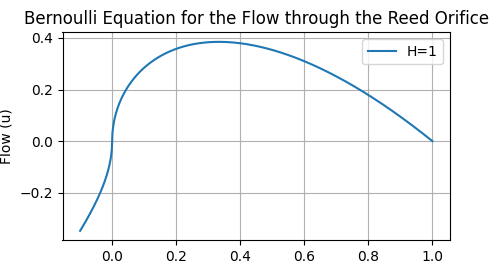

In [4]:
fig, ax = plt.subplots(figsize=(5, 2.7))
ax.plot(p_delta,u, label='H=1')
ax.grid(1)
ax.set_xlabel('normalized $p\Delta$')
ax.set_ylabel('Flow (u)')
ax.legend()
ax.set_title('Bernoulli Equation for the Flow through the Reed Orifice')
plt.show()

As I can see the resulting Figure 1 follows similarly to that of the desired graphic presented above without the need of determining the required parameters of H, etc. If I are to use this as a haptic effect, further conditioning of the data is required. First, I must consider normalizing the non-negative initial values of the pressure and flow between 0 and 1. But first, let’ see what happens when I wrap the pressure between 0 and 360.

In [5]:
p_delta = np.arange(0,360.001,0.001)
p_delta_diff = 1-(p_delta/360)
p_delta_sign = np.sign(p_delta)
p_delta_sqrt = np.sqrt(np.abs(p_delta))
u = (p_delta_sqrt*p_delta_diff*p_delta_sign)
u = u/np.max(u)

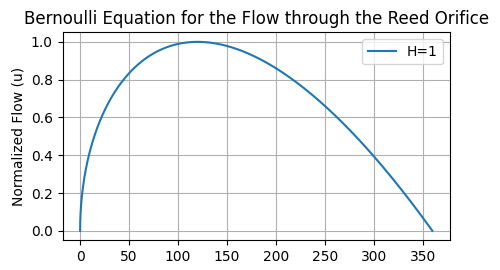

In [6]:
fig, ax = plt.subplots(figsize=(5, 2.7))
ax.plot(p_delta,u, label='H=1')
ax.grid(1)
ax.set_xlabel('Angle (Deg)')
ax.set_ylabel('Normalized Flow (u)')
ax.legend()
ax.set_title('Bernoulli Equation for the Flow through the Reed Orifice')
plt.show()

The problem with this approach is that it requires the flow to be precomputed, locking in H and k into the array. This requires a recalculation of the array every time one of the variables changes making it inefficient for haptics. A better way can be achieved parametrically. Let's look at the equations from earlier.

\begin{align}
 \beta &= \sqrt{\frac{2}{\rho}}wH \\
 p_c &= \frac{kH}{A_r} \\
 u &= \beta \sqrt{|p\Delta| } \left(1 - \frac{p\Delta }{p_c}\right)sgn(p\Delta)
\end{align}

The equilibrium position H appears in both the reed closure pressure and the scaling variable $\beta$. This would be a perfect variable to expose and map to the model. K, the spring constant is also a good parameter to expose as it works in conjunction with H in $p_c$. $A_r$ affects the weight of $\frac{p\Delta }{p_c}$ and $\sqrt{\frac{2}{\rho}}w$ is technically the amplitude value that I shall visit later on in this paper. Both set of variables can be exposed in future iterations of the haptic model if greater fine tuning of the curve is desired. For now, I shall analyze how H and k interacts with the model.

I am left with:
    $$
     u = H \sqrt{|p\Delta| } \left(1 - \frac{p\Delta }{kH}\right)sgn(p\Delta)
    $$

In [7]:
def simple_mult(x,y):
    return x*y
def u(x,H,k,func):
    arr = H * np.sqrt(np.abs(x))*(1-x/func(H,k))*np.sign(x)
    return arr

Here, the Flow curve is varying with the reed tip equilibrium (H),
<img src="H_var.gif" width="500" align="center">
and here with the spring constant (k).
<img src="k_var.gif" width="500" align="center">

Now, both variables affect the amplitude and zero crossing point of the effect showing that on a clarinet, the stiffness of the reed (spring constant) and the reed tip equilibrium, both affect the maximum flow. Mathematically, this is visible when taking the derivative of the flow equation and finding the zero point of the equation.

In this case, lets assume that the pressure (p) is positive.

\begin{align}
    \frac{du}{dp\Delta } &= \frac{d}{dp\Delta }\left[\sqrt{p\Delta } \left(H - \frac{p\Delta }{k}\right) \right] \\
    u^{'}&= \frac{p\Delta ^{-\frac{1}{2}}}{2}\left( H-\frac{3}{k}p\Delta \right)
\end{align}

When $u^{'} = 0$, it marks the critical point in which the flow value goes from increasing to decreasing in value, in other words the maximum value of the curve:
\begin{align}
    0 &= \frac{p\Delta ^{-\frac{1}{2}}}{2}\left( H-\frac{3}{k}p\Delta \right)\\
    0 &= \left( H-\frac{3}{k}p\Delta \right)\\
    H &= \frac{3}{k}p\Delta\\
    p\Delta &= \frac{Hk}{3} 
\end{align}
    
Inputting this value for the pressure difference back into the curve gives:

\begin{align}
    u &= \sqrt{p\Delta } \left(H - \frac{p\Delta }{k}\right)  \\
    &= \sqrt{\frac{Hk}{3} } \left(H - \frac{H}{3}\right)\\
    &= \sqrt{\frac{Hk}{3}} \left(H - \frac{H}{3}\right)\\
    &= \sqrt{\frac{H^3k}{3}} \left(1 - \frac{1}{3}\right)\\
    &= \sqrt{\frac{H^3k}{3}} \frac{2}{3}\\
    &= \sqrt{\frac{4H^3k}{27}}\\
\end{align}

Now, lets set $u = 1$, the desired max value, the relation between H and K can now be determined to keep the max flow to one.

\begin{align}
    u &= \sqrt{\frac{4H^3k}{27}}\\
    1 &= \sqrt{\frac{4H^3k}{27}}\\
    1 &= \frac{4H^3k}{27} \text{ for x > 0}\\
    k &= \frac{27}{4H^3}
\end{align}

Now, the spring constant (k) is dependent on the tip equilibrium (H), (something that is not true within the real-world model).

To find the optimal value of H, the equation must be solved for $u = 0$ and $x = 1$.

\begin{align}
u &= \left(H \sqrt{|p\Delta| } - \frac{\sqrt{|p\Delta| }p\Delta }{k}\right)sgn(p\Delta)\\
0 &= H - \frac{1}{k}\\
H &= \frac{1}{k}\\
H &= \frac{4H^3}{27}\\
H^2 &= \frac{27}{4}\\
H &= \sqrt{\frac{27}{2}}
\end{align}


In [8]:
def u_N(x,H):
    k = 27/(H**3*4)
    arr = np.sqrt(np.abs(x))*(H-x/k)*np.sign(x)
    return arr

This shows what happens when k is dependent on H (normalized), the amplitude remains 1.
<img src="H_normalized.gif" width="500" align="center">

The variable 'A' can be added to represent $\sqrt{\frac{2}{\rho}}w$ as previously mentioned that can control the amplitude of the flow independently.

In [9]:
p_delta = np.linspace(-0.03,1,100)
p_sqrt_delta = np.sqrt(np.abs(p_delta))
p32 = p_delta*p_sqrt_delta
p_sign_delta = np.sign(p_delta)

def u_N_Amp(H,A):
    k = 27/(H**3*4)
    arr = A * (p_sqrt_delta*H-p32/k)*p_sign_delta
    return arr

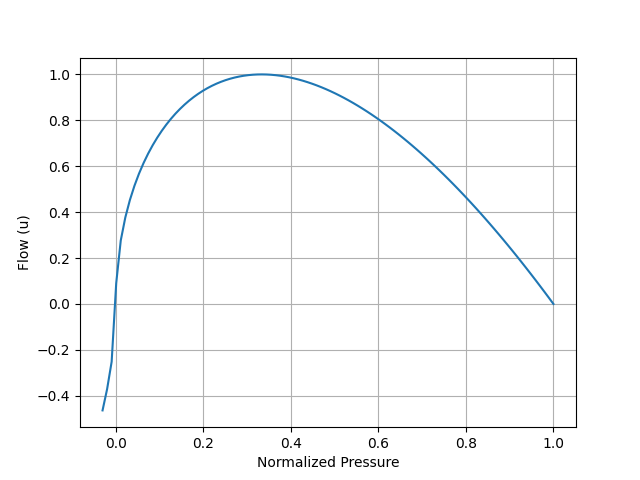

In [10]:
init_H = np.sqrt(27)/2
init_A = 1

fig, ax = plt.subplots()
ax.grid(1)
line, = ax.plot(p_delta, u_N_Amp(init_H, init_A))
ax.set_xlabel('Normalized Pressure')
ax.set_ylabel('Flow (u)')


# resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
# button = Button(resetax, 'Reset', hovercolor='0.975')
# def reset(event):
#     H_slider.reset()
#     K_slider.reset()
# button.on_clicked(reset)

plt.show()


# Discussion
Why would this be a useful design parameter? It has been discussed in mapping literature that cross-coupled mappings lead to interesting interactions with DMIs. For example, in Hunt et al. (2002) To have the parameters decoupled, the user would have a more transparent mapping of parameters, but the depth and interaction would be lacking. This is of course a perfect thing to test with some participants. To have two models, with the spring constant and tip equilibrium coupled and decoupled. Like that I can study how the users interact with each model.

So far, the mathematical analysis of the Reed Model has been done. It is no wonder why the clarinet is so popular. Its timbre and mappings of acoustical parameters to controls render the clarinet an optimal wind instrument. From what I have analyzed above, the user has a very fine control over most of the mouthpiece’s variables. They can change the mouthpiece in different lays, inner widths for easier or harder control affecting the timbre but also the tip equilibrium. They can change the reed hardness, affecting the spring constant. The lip position affects the damping coefficient of the clarinets sound synthesis model. The closing of the tone holes affects the pressure difference felt in the mouthpiece. This creates an interactive model where the note played helps determine how much pressure the user needs to achieve an optimal flow.

That last part is of particular interest to us and will be modeled as part of the DMI. Technically, the lower the note, the more holes are covered. This results in higher pressure in the clarinet column and less pressure for the user to input into the system. Inversely, the higher the note is less the pressure. But this aspect will be explored later once the basic model has been implemented.

Finally, before I continue to condition the model for the TorqueTuner, I shall discuss the reed model in terms of a convergent modal system. Depending on how much pressure is put on the mouthpiece, different sounds can be generated. A negative pressure, sucking on the mouthpiece will induce a percussive sound on the clarinet called tongue slapping. At pressures above the optimal flow point, beating will occur up until the reed shuts. As such, at each edge cases of the model, different effects can be played. This falls in line with Fels, Sidney, et al. (2002) view on mappings and DMIs, one can even say that what I am modeling is the metaphor of a clarinet. How well it is integrated into the DMI will therefor determine its transparency for the user and the crowd. This also means that the choice of synthesis model will be crucial for transparency.

$$
u = H \sqrt{|p\Delta| } \left(1 - \frac{p\Delta }{kH}\right)sgn(p\Delta)
$$
Now in terms of implementing the model on the TT, calculation efficiency is crucial. Right now, the models is of $O(x^{\frac{3}{2}})$ on account of the pressure values being square rooted and multiplied to each other at every cycle. So there is room for improvements algorithmically. 

For starters, the pressure values can be precomputed and stored in either a simple array or a hash table. Reducing the big O notation to approximately 0(n). I can also reduce the amount of operations needed:

$$
u = \left(H \sqrt{|p\Delta| } - \frac{\sqrt{|p\Delta| }p\Delta }{k}\right)sgn(p\Delta)
$$

Here, the pressure values can be precomputed leading to an abstracted equation:
    
$$
u[n] = \left(H x_A[n] - \frac{x_B[n]}{k} \right)sgn(p\Delta)
$$

Where $x_A[n]$ and $x_B[n]$ are precomputed values of pressure that are accessed with a indexed value in the TT. This results in approximately $O(Hn+1) + O(k^{-1}n+1) \leq O(x^{\frac{3}{2}})$

Now, from figure 1 at the beginning of this notebook, the maximum flow only reaches 0.4 and not 1. To resolve this issue, I have determined the relation between H and k to keep the max flow at 1 and, as a result, affecting the stretching factor. This is not optimal as it removed a degree of manipulation from the equation. It did however give us the optimal curve for us to do an initial implementation. 

Re-evaluation of the variables H and k must be done when designing in more depth the mapping between the reed model and another controller that can control those parameters. Like the z and y axis (height and pressure) on the Linnstrument.

Now, let’s generate the values for the effect starting with the pressure values. The TT angle has a range from 0 to 3600 integer steps and a max torque of 180.

In [11]:
x = np.linspace(0, 1,3601)
x_A = np.sqrt(np.abs(x))
x_B = x*x_A
x_sgn = np.sign(x)

H = np.sqrt(27)/2
k = 27/(H**3*4)


pressure = np.stack((x,x_A,x_B,x_sgn),axis=1)
print(H,k)
print(pressure.shape)
np.set_printoptions(threshold=10)
print(pressure)

2.598076211353316 0.3849001794597505
(3601, 4)
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.77777778e-04 1.66666667e-02 4.62962963e-06 1.00000000e+00]
 [5.55555556e-04 2.35702260e-02 1.30945700e-05 1.00000000e+00]
 ...
 [9.99444444e-01 9.99722184e-01 9.99166782e-01 1.00000000e+00]
 [9.99722222e-01 9.99861101e-01 9.99583362e-01 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00]]


Now that I have the values, I can write them to the headfile to be stored and used.

In [12]:
# with open('TorqueTuner/software/include/pressure_table_values.h', 'w') as f:
#     f.write('const float rp_table[] = {')
#     for var in x_A[:(len(x)-1)]:
#         f.write(str(var) +', ') 
#     f.write(str(x_A[len(x)-1]))
#     f.write('};\n')
#     f.write('const float rp_B_table[] = {')
#     for var in x_B[:(len(x)-1)]:
#         f.write(str(var) +', ') 
#     f.write(str(x_B[len(x)-1]))
#     f.write('};\n')
#     f.write('const int rp_sgn_table[] = {')
#     for var in x_sgn[:(len(x)-1)]:
#         f.write(str(int(var)) +', ') 
#     f.write(str(int(x_sgn[len(x)-1])))
#     f.write('};\n')
    
#     f.write("const float H_init = " + str(H) + ';\n')
#     f.write("const float k_init = " + str(k) + ';\n')

# Conclusion

In this paper, an initial exploration of the reed modal and implementation on the TorqueTuner was done. The results proved promising for further exploration of its mappings in a DMI. Future work involves extending the haptic model to test different versions, generating different mappings, and choosing one or more sound synthesis methods with the purpose of creating a DMI. I hope that this model can be used in the future as an example of haptically enabled DMIs. With continued work, user-test data and literature surrounding this project, I can continue to improve our in-house Haptic tool in a quantifiable manner.

# Bibliography

G. P. Scavone. MUMT-618 [Lecture notes].
McGill University. , 2004-2023.

N. H. Fletcher and T. D. Rossing.
The Physics of Musical Instruments.
Springer-Verlag, New York, 1991.

A. da Silva, G. Scavone, and M. van Walstijn.
Numerical simulations of fluid-structure interactions in single-reed mouthpieces.
Journal of the Acoustical Society of America, 122 (3): 1798–1810, 2007.

Hunt, Andy & Dd, Yo & Wanderley, Marcelo & Paradis, Matthew. (2002). The Importance of Parameter Mapping in Electronic Instrument Design. Journal of New Music Research. 32. 10.1076/jnmr.32.4.429.18853. 

Fels, Sidney, et al. “Mapping Transparency through Metaphor: Towards More Expressive Musical Instruments.” Organised Sound, vol. 7, no. 2, Aug. 2002, pp. 109–26. DOI.org (Crossref), https://doi.org/10.1017/S1355771802002042.

In [14]:
# init_H = np.sqrt(27)/2
# H = np.linspace(5,2,200)
# p_delta = np.linspace(-0.03,1,200)

# fig, ax = plt.subplots()
# ax.grid(1)
# line, = ax.plot(p_delta, u_N(p_delta, init_H))
# ax.set_xlabel('Normalized Pressure')
# ax.set_ylabel('Flow Flow (u)')

# def update(i):
#     line.set_ydata(u_N(p_delta, H[i]))
#     fig.canvas.draw_idle()

# plt.grid(1)

# plt.show()


# ani = animation.FuncAnimation(fig, update, repeat=True,
#                                     frames=len(H) - 1, interval=50)

# ani.save("H_normalized.gif")